In [ ]:
import geopandas as gpd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

In [3]:
# From (Ida) https://www.dropbox.com/scl/fi/mr3gsng7skxkoqqekgc0g/adm3_kecas_2000_w_overlap_pop_102028.zip?dl=0&e=1&file_subpath=%2Fadm3_kecas_2000_w_overlap_pop_102028.shp&rlkey=w7va679ndd0wjhesu87gwpao9
gen_map = gpd.read_file("overlap_pop.shp")
# From https://data.humdata.org/dataset/hotosm_idn_waterways
water_map = gpd.read_file("hotosm_idn_waterways_polygons_shp/hotosm_idn_waterways_polygons_shp.shp")
# From https://osmdata.openstreetmap.de/data/land-polygons.html
coastline_map = gpd.read_file("land-polygons-complete-4326/land_polygons.shp")

# Exploring Data

In [4]:
print(gen_map.head())

      fid PROVCODE PKABCODE PKKECODE              PROVNAME   KABNAME  \
0  2456.0       11     1101  1101010  DAERAH ISTIMEWA ACEH  SIMEULUE   
1  2227.0       11     1101  1101020  DAERAH ISTIMEWA ACEH  SIMEULUE   
2  2248.0       11     1101  1101030  DAERAH ISTIMEWA ACEH  SIMEULUE   
3  2288.0       11     1101  1101040  DAERAH ISTIMEWA ACEH  SIMEULUE   
4  2320.0       11     1101  1101050  DAERAH ISTIMEWA ACEH  SIMEULUE   

           KECNAME          area      perimeter  2000_urban  2000_urb_1  \
0   TEUPAH SELATAN  2.262614e+08  128508.765683         0.0         0.0   
1   SIMEULUE TIMUR  4.411722e+08  228977.863027         0.0         0.0   
2  SIMEULUE TENGAH  3.599440e+08  206434.338326         0.0         0.0   
3           SALANG  2.426641e+08   79899.557626         0.0         0.0   
4   SIMEULUE BARAT  5.554454e+08  315034.371687         0.0         0.0   

   fuas_w_are  fuas_w_a_1  transmigra  transmig_1     pop20_sum  pop20_mean  \
0         0.0         0.0         0.0

In [5]:
print(water_map.head())

                  name name_en waterway covered width depth layer blockage  \
0                 None    None     None    None  None  None  None     None   
1                 None    None     None    None  None  None  None     None   
2                 None    None     None    None  None  None  None     None   
3  Danau Alam Oelbubuk    None     None    None  None  None  None     None   
4                 None    None     None    None  None  None  None     None   

  tunnel natural water source name_id     osm_id   osm_type  \
0   None   water  None   None    None  424314432  ways_poly   
1   None   water  None   None    None  568532400  ways_poly   
2   None   water  None   None    None  334787374  ways_poly   
3   None   water  lake   None    None  734701095  ways_poly   
4   None   water  lake   None    None  658377287  ways_poly   

                                            geometry  
0  POLYGON ((116.47372 -8.55795, 116.47373 -8.557...  
1  POLYGON ((98.55552 3.50067, 98.55553 3.

In [6]:
print(coastline_map.head())

   FID                                           geometry
0    0  POLYGON ((-4.94237 55.72545, -4.94192 55.72558...
1    1  POLYGON ((-4.94051 55.72458, -4.94049 55.72407...
2    2  POLYGON ((-4.7329 55.52496, -4.7338 55.52495, ...
3    3  POLYGON ((-4.95385 55.1629, -4.95388 55.16341,...
4    4  POLYGON ((-1.75363 50.72293, -1.75358 50.72303...


# Cleaning Data and Calculating Distances

In [ ]:
# Setting CRS match South Asia
gen_map = gen_map.set_crs('ESRI:102028')

In [ ]:
# Since waterways has many different types, I filter for rivers and streams
rivers_only = water_map[water_map['water'].isin(['river', 'stream'])].copy()
rivers_only.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# Reproject to match village CRS
rivers_only = rivers_only.to_crs(gen_map.crs)

# Compute centroid of each polygon
gen_map['centroid'] = gen_map.geometry.centroid

# Compute distance from each centroid to the nearest river/stream point
gen_map['dist_to_river'] = gen_map['centroid'].apply(lambda pt: rivers_only.distance(pt).min())

In [ ]:
# Sanity check to see if values are reasonable in meters
print(gen_map['dist_to_river'].describe())

count      3887.000000
mean      16754.161069
std       20004.805252
min           0.000000
25%        4780.258164
50%       11074.983193
75%       21133.912197
max      295603.612814
Name: dist_to_river, dtype: float64


In [ ]:
rivers_only.crs

<Projected CRS: ESRI:102028>
Name: Asia_South_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Asia - South
- bounds: (25.0, -10.0, 165.0, 30.0)
Coordinate Operation:
- name: Asia_South_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
gen_map['dist_to_river'].sort_values(ascending=True)

677          0.000000
3225         0.000000
1434         0.000000
3246         0.000000
3715         0.000000
            ...      
3837    152585.278674
600     152933.775754
3836    186087.121735
3834    278245.639467
3835    295603.612814
Name: dist_to_river, Length: 3887, dtype: float64

In [14]:
land = coastline_map.to_crs(gen_map.crs)

In [ ]:
#Clipping to Indonesia (in future just load gpkg file land_indonesia as done in next cell))
#gen_map['geometry'] = gen_map.buffer(0)
# land['geometry'] = land.buffer(0)
# # Create one polygon covering all of Indonesia
# indonesia_shape = gen_map.geometry.union_all()  # multipolygon

# # Clip global land to Indonesia extent
# land_indonesia = land.clip(indonesia_shape)
# land_indonesia.to_file("land_indonesia.gpkg", layer="land", driver="GPKG")

In [16]:
land_indonesia = gpd.read_file("land_indonesia.gpkg", layer="land")

In [ ]:
# Reproject into same CRS as gen_map
land_indonesia = land_indonesia.to_crs("ESRI:102028")

def remove_all_holes(geom):
    if geom.geom_type == "Polygon":
        return Polygon(geom.exterior)
    elif geom.geom_type == "MultiPolygon":
        return MultiPolygon([Polygon(p.exterior) for p in geom.geoms])
    else:
        return geom

land_no_holes = land_indonesia.copy()
land_no_holes["geometry"] = land_no_holes.geometry.apply(remove_all_holes)

# Getting union those hole‐free polygons
coast_union = unary_union(land_no_holes.geometry)

# Extract the boundary of the unioned geometry
coastline_lines = coast_union.boundary

gen_map = gen_map.to_crs(land_no_holes.crs)
gen_map["centroid"] = gen_map.geometry.centroid

# Measure distance from each centroid to the coastline lines 
def get_dist_to_coast(pt):
    return pt.distance(coastline_lines)

gen_map["dist_to_coast"] = gen_map["centroid"].apply(get_dist_to_coast)


In [18]:
gen_map.columns

Index(['fid', 'PROVCODE', 'PKABCODE', 'PKKECODE', 'PROVNAME', 'KABNAME',
       'KECNAME', 'area', 'perimeter', '2000_urban', '2000_urb_1',
       'fuas_w_are', 'fuas_w_a_1', 'transmigra', 'transmig_1', 'pop20_sum',
       'pop20_mean', 'geometry', 'centroid', 'dist_to_river', 'dist_to_coast'],
      dtype='object')

In [19]:
distances = gen_map[['PKKECODE', 'PROVNAME', 'KABNAME', 'KECNAME', 'dist_to_river', 'dist_to_coast', 'geometry']]
distances

,PKKECODE,PROVNAME,KABNAME,KECNAME,dist_to_river,dist_to_coast,geometry
0,1101010,DAERAH ISTIMEWA ACEH,SIMEULUE,TEUPAH SELATAN,125391.703708,3210.642168,"MULTIPOLYGON (((-3073443.477 1831948.533, -307..."
1,1101020,DAERAH ISTIMEWA ACEH,SIMEULUE,SIMEULUE TIMUR,130813.866710,7198.627272,"MULTIPOLYGON (((-3115781.666 1862684.13, -3115..."
2,1101030,DAERAH ISTIMEWA ACEH,SIMEULUE,SIMEULUE TENGAH,138749.582867,3992.271398,"MULTIPOLYGON (((-3124856.47 1886890.631, -3124..."
3,1101040,DAERAH ISTIMEWA ACEH,SIMEULUE,SALANG,144430.116368,4905.572997,"MULTIPOLYGON (((-3153036.779 1887752.172, -315..."
4,1101050,DAERAH ISTIMEWA ACEH,SIMEULUE,SIMEULUE BARAT,134126.757651,4077.155181,"MULTIPOLYGON (((-3140039.612 1896070.064, -314..."
...,...,...,...,...,...,...,...
3882,8202050,MALUKU UTARA,HALMAHERA TENGAH,MABA,31075.831389,1459.696027,"MULTIPOLYGON (((334896.854 1814053.358, 331315..."
3883,8202060,MALUKU UTARA,HALMAHERA TENGAH,WASILE,50501.247541,3405.072871,"MULTIPOLYGON (((296689.043 1825455.394, 295779..."
3884,8271010,MALUKU UTARA,KOTA TERNATE,PULAU TERNATE,88617.012804,2773.645836,"MULTIPOLYGON (((256027.715 1827616.579, 255936..."
3885,8271020,MALUKU UTARA,KOTA TERNATE,TERNATE SELATAN,82858.602072,2247.496575,"MULTIPOLYGON (((258384.548 1834365.662, 258384..."


In [ ]:
# More sanity check to make sure values are reasonable
distances.sort_values(by='dist_to_coast', ascending=True)

,PKKECODE,PROVNAME,KABNAME,KECNAME,dist_to_river,dist_to_coast,geometry
3463,7103180,SULAWESI UTARA,SANGIR TALAUD,NANUSA,48416.746242,41.104038,"MULTIPOLYGON (((236342.6 2269045.316, 236356.5..."
2882,5303100,NUSA TENGGARA TIMUR,KUPANG,SEMAU,12603.804943,59.808189,"MULTIPOLYGON (((-163455.312 552076.855, -16333..."
621,1472030,RIAU,BATAM,GALANG,21320.807425,61.032879,"MULTIPOLYGON (((-2226005.861 1748517.61, -2225..."
146,1201010,SUMATERA UTARA,NIAS,PULAU-PULAU BATU,33792.145846,69.347907,"MULTIPOLYGON (((-2804006.89 1621108.699, -2804..."
2594,3529240,JAWA TIMUR,SUMENEP,ARJASA,141256.824555,78.168763,"MULTIPOLYGON (((-986842.372 927406.496, -98679..."
...,...,...,...,...,...,...,...
3165,6203220,KALIMANTAN TENGAH,KAPUAS,RUNGAN,24427.602085,226238.628516,"POLYGON ((-1230167.593 1584826.024, -1234553.7..."
3160,6203170,KALIMANTAN TENGAH,KAPUAS,KAPUAS TENGAH,22756.718725,231099.069889,"POLYGON ((-1149289.818 1580650.032, -1151049.8..."
3142,6202250,KALIMANTAN TENGAH,KOTAWARINGIN TIMUR,MARIKIT,75219.833635,233904.818758,"POLYGON ((-1337959.357 1594259.923, -1338646.4..."
3143,6202260,KALIMANTAN TENGAH,KOTAWARINGIN TIMUR,SANAMAN MANTIKEI,77634.374800,241368.500448,"POLYGON ((-1280156.311 1594572.343, -1279887.7..."


In [21]:
distances.to_csv("distances.csv", index=False)

# Visualizing Distances

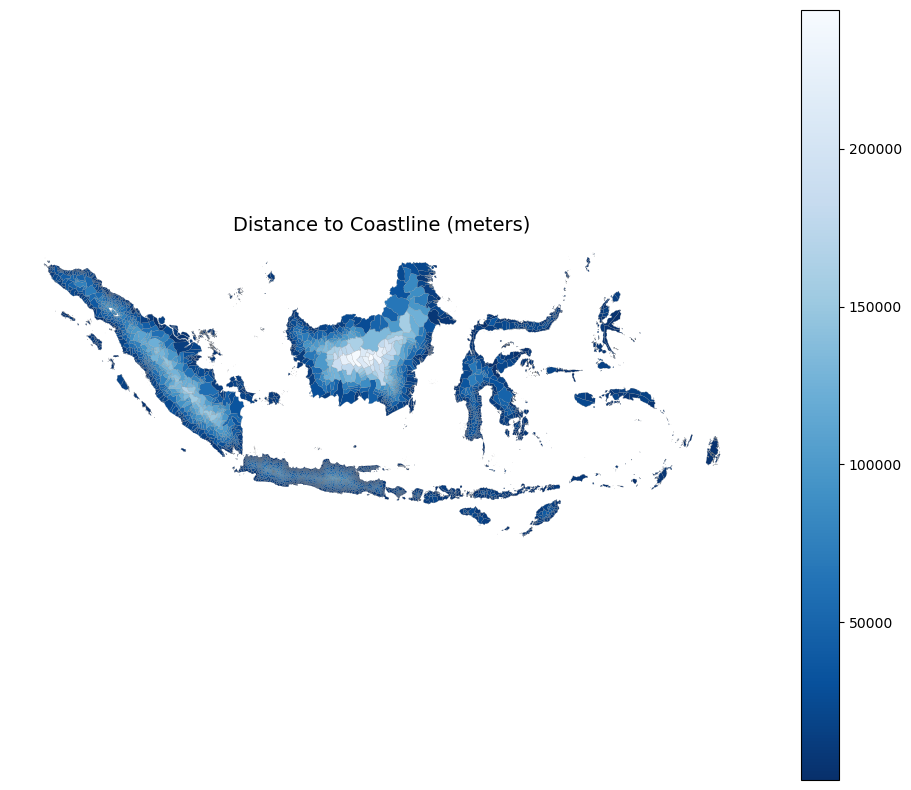

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
distances.plot(column='dist_to_coast', cmap='Blues_r', linewidth=0.1, edgecolor='gray', legend=True, ax=ax)
ax.set_title("Distance to Coastline (meters)", fontsize=14)
ax.axis('off')
plt.savefig("distance_to_coastline", dpi=600, bbox_inches='tight')
plt.show()

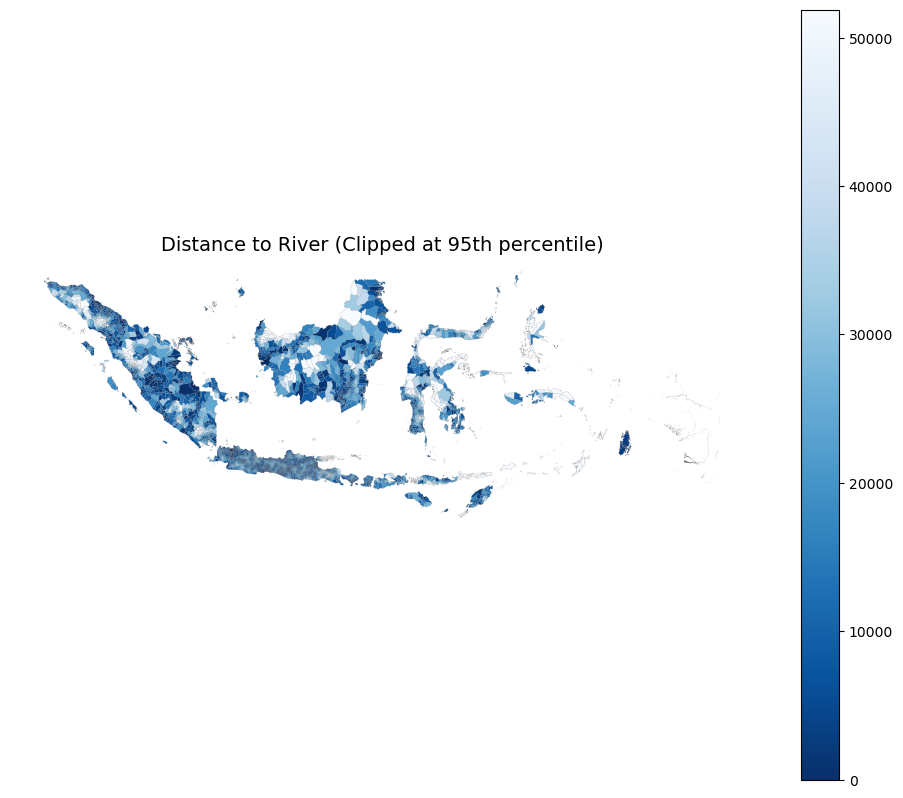

In [ ]:
clip_val = gen_map['dist_to_river'].quantile(0.95)
gen_map['dist_to_river_clip'] = gen_map['dist_to_river'].clip(upper=clip_val)

# Now plot the clipped version
fig, ax = plt.subplots(figsize=(12, 10))
gen_map.plot(
    column='dist_to_river_clip',
    cmap='Blues_r',
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    k=5,
    ax=ax
)
rivers_only.plot(ax=ax, color='black', linewidth=5)
ax.set_title("Distance to River (Clipped at 95th percentile)", fontsize=14)
ax.axis('off')
plt.savefig("river_distance_clipped.png", dpi=600, bbox_inches='tight')
plt.show()

